In [1]:
# !pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
def load_dataset():
    dataset = pd.read_csv("googleplaystore.csv")
    return dataset
dataset = load_dataset()
dataset

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


In [3]:
def print_summarize_dataset(dataset):
    print(dataset.shape)
    print("\n")
    print(dataset.describe())
    print("\n")
    print(dataset.head())
    print("\n")
print_summarize_dataset(load_dataset())

(10841, 13)


            Rating
count  9367.000000
mean      4.193338
std       0.537431
min       1.000000
25%       4.000000
50%       4.300000
75%       4.500000
max      19.000000


                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free   

In [4]:
def clean_dataset(data):
    data.dropna(axis=0, inplace=True)
    data["Reviews"] = data["Reviews"].astype(np. int)
    data["Category"] = data["Category"].astype("string")
    data["Installs"] = data["Installs"].str.replace("+", "").str.replace(",","").astype(int)
    data["Last Updated"] = pd.to_datetime(data['Last Updated'])
    data["Genres"] = data["Genres"].str.replace("&", "and" ).astype ("string")
    data["Size" ] = data["Size"].str.replace("Varies with device","NaN")
    data_size = data[data["Size"].str.contains("k",regex=False)]
    data_size["Size"] = data_size["Size"].str.replace("k", '').astype(float)/1000
    data["Size"].update(data_size["Size"])
    data["Size"] = data["Size"].str.replace("M", '').astype(float)
    data["Size"] = data["Size"].fillna(np.mean(data["Size"]))
    data["Content Rating"] = data["Content Rating"].str.replace("+", '')
    return data
clean_data = clean_dataset(dataset)
clean_data

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.000000,10000,Free,0,Everyone,Art and Design,2018-01-07,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.000000,500000,Free,0,Everyone,Art and Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.700000,5000000,Free,0,Everyone,Art and Design,2018-08-01,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.000000,50000000,Free,0,Teen,Art and Design,2018-06-08,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.800000,100000,Free,0,Everyone,Art and Design;Creativity,2018-06-20,1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10834,FR Calculator,FAMILY,4.0,7,2.600000,500,Free,0,Everyone,Education,2017-06-18,1.0.0,4.1 and up
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53.000000,5000,Free,0,Everyone,Education,2017-07-25,1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.600000,100,Free,0,Everyone,Education,2018-07-06,1.0,4.1 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,23.746317,1000,Free,0,Mature 17,Books and Reference,2015-01-19,Varies with device,Varies with device


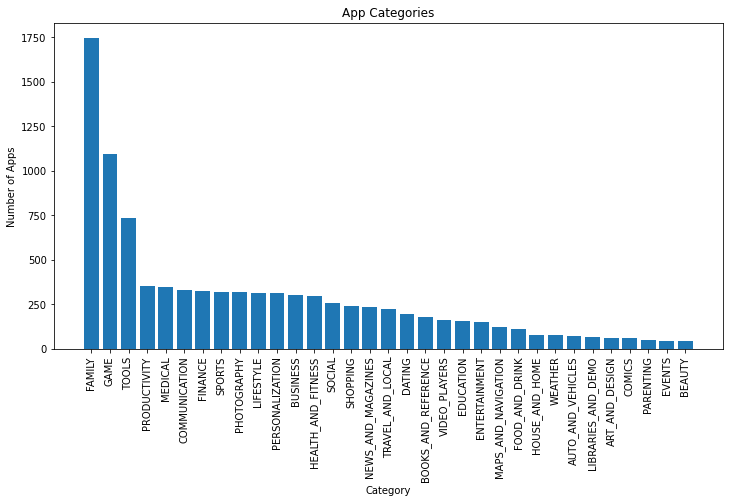

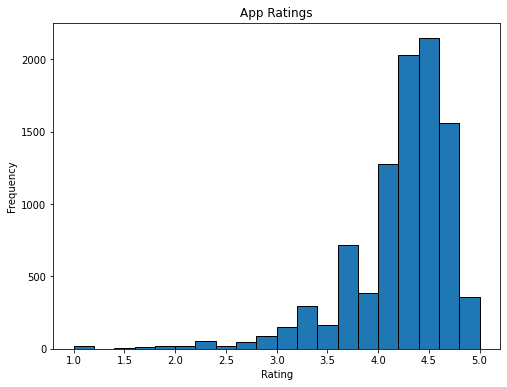

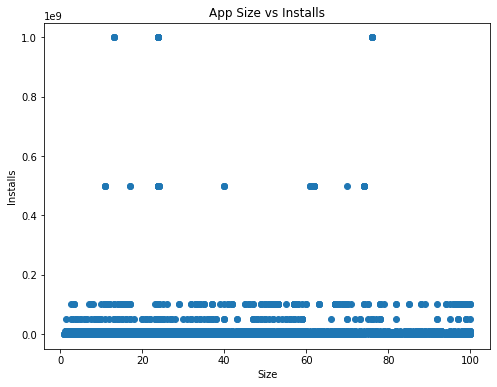

In [5]:
# Explore app categories
categories = clean_data["Category"].value_counts()
plt.figure(figsize=(12,6))
plt.bar(categories.index, categories.values)
plt.title("App Categories")
plt.xticks(rotation=90)
plt.xlabel("Category")
plt.ylabel("Number of Apps")
plt.show()

# Explore app ratings
plt.figure(figsize=(8,6))
plt.hist(clean_data["Rating"], bins=20, edgecolor="black")
plt.title("App Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# Explore app size and installs
plt.figure(figsize=(8,6))
plt.scatter(clean_data["Size"], clean_data["Installs"])
plt.title("App Size vs Installs")
plt.xlabel("Size")
plt.ylabel("Installs")
plt.show()

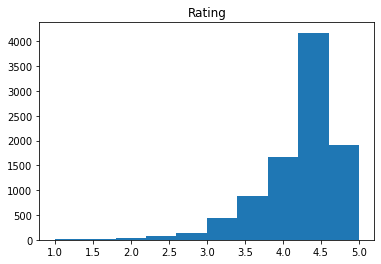

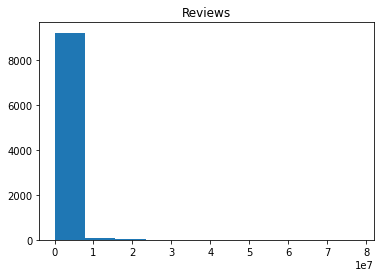

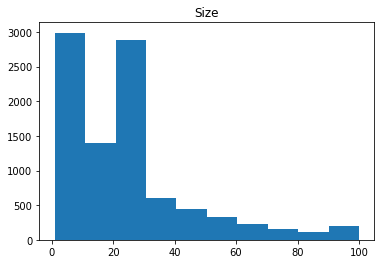

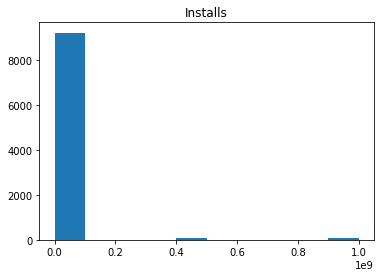

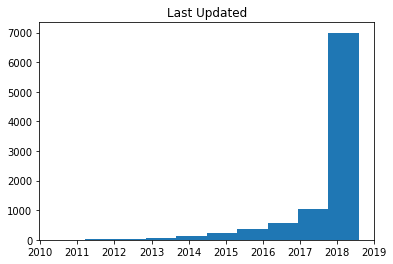

In [6]:
def print_histograms(dataset):
    dataset = dataset.drop(["App", 'Category', "Type", 'Content Rating', "Genres", "Current Ver", "Android Ver", "Price"], axis=1)
    for i in dataset.columns:
        plt.hist(dataset[f"{i}"])
        plt.title(i)
        plt.show()
print_histograms(clean_data)

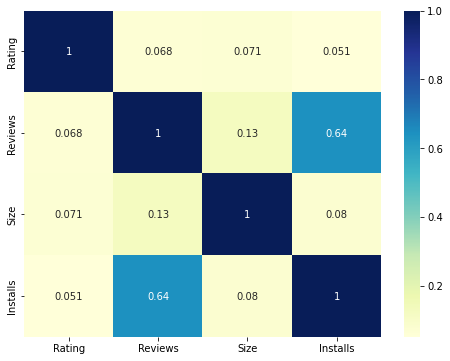

In [7]:
def compute_correlations_matrix(dataset):
    dataset = dataset.drop(["App", 'Category', "Type", 'Content Rating',
                            "Genres", "Current Ver", "Android Ver"], axis=1)
    d_corr = dataset.corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(d_corr, annot=True, cmap="YlGnBu")
    plt.show()
compute_correlations_matrix(clean_data)

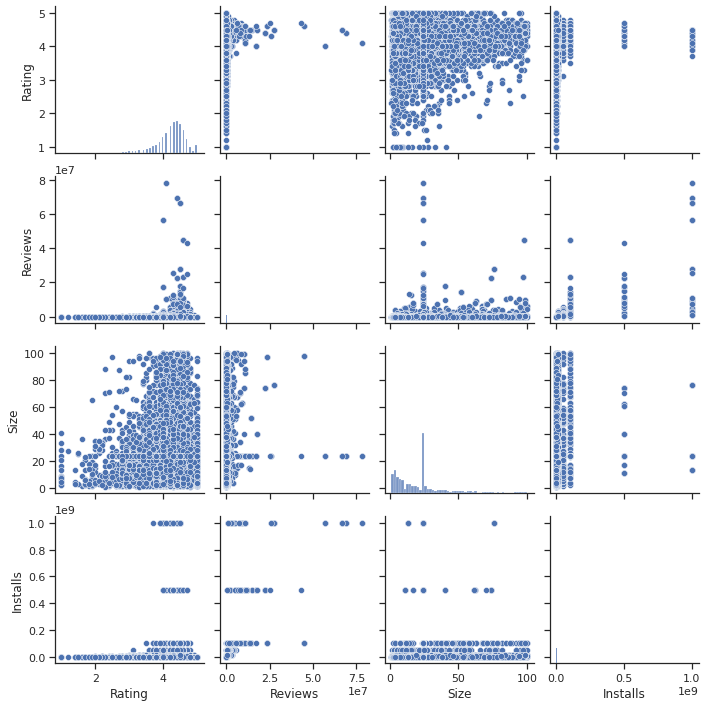

In [10]:
def print_scatter_matrix(dataset):
    sns.set(style="ticks", color_codes=True)
    sns.pairplot(dataset)
print_scatter_matrix(dataset)

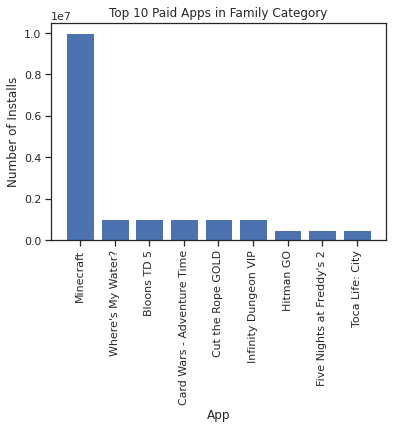

In [11]:


family_paid = clean_data[(clean_data['Category'] == 'FAMILY') & (clean_data['Type'] == 'Paid')]
family_paid = family_paid.sort_values('Installs', ascending=False)
top_apps = family_paid.head(10)

plt.bar(top_apps['App'], top_apps['Installs'])
plt.xlabel('App')
plt.ylabel('Number of Installs')
plt.title('Top 10 Paid Apps in Family Category')
plt.xticks(rotation=90)
plt.show()

In [1]:
!gandalf



 ██████╗ ██╗    ██╗ █████╗ ███████╗ █████╗ ██████╗    ██╗ ██████╗ 
██╔═══██╗██║    ██║██╔══██╗██╔════╝██╔══██╗██╔══██╗   ██║██╔═══██╗
██║   ██║██║ █╗ ██║███████║███████╗███████║██████╔╝   ██║██║   ██║
██║▄▄ ██║██║███╗██║██╔══██║╚════██║██╔══██║██╔══██╗   ██║██║   ██║
╚██████╔╝╚███╔███╔╝██║  ██║███████║██║  ██║██║  ██║██╗██║╚██████╔╝
 ╚══▀▀═╝  ╚══╝╚══╝ ╚═╝  ╚═╝╚══════╝╚═╝  ╚═╝╚═╝  ╚═╝╚═╝╚═╝ ╚═════╝ 
																																 
Booting Gandalf v4.1.12-deab022 (production)
Loading parameters:  OK
User kurganov_s connection: OK


<MY_MOBAPP_STUDIO>
Directory . exists: OK
Pushing exercise: OK
Printing your report:

      REPORT        MY MOBAPP STUDIO 

 Status             SUCCESS          
 Execution Runtime  5.415127         
 Score              [======] 6/6     


Checks detail Report:

 TEST CLEAN DATASET  SUCCESS 



 TEST COMPUTE CORRELATIONS MATRIX  SUCCESS 



 TEST LOAD DATASET  SUCCESS 



 TEST PRINT HISTOGRAMS  SUCCESS 



 TEST PRINT SCATTER MATRIX  SUCCESS 



 TEST PR